In [8]:
import site
import pandas as pd
import numpy as np
import io
from PIL import Image

# 1. Load the parquet file
# Ensure 'train.parquet' is in your current directory
train_df = pd.read_parquet("train.parquet")

# 2. Define helper functions for image decoding
def extract_bytes(blob):
    """
    Unwraps a dictionary-wrapped binary payload if present, 
    otherwise returns the blob directly.
    """
    if isinstance(blob, dict):
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Converts raw image bytes (e.g., JPEG/PNG) into a 2D numpy array (grayscale).
    """
    img = Image.open(io.BytesIO(b))
    return np.array(img)

# 3. Apply the processing to the 'image' column
train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))

# Display the first few rows to verify
print(train_df.head())

                                               image  label
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      3
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      3
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2


In [12]:
# Check columns
print("Columns in train_df:", train_df.columns.tolist())
print(train_df.head())

Columns in train_df: ['image', 'label']
                                               image  label
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      3
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      3
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2


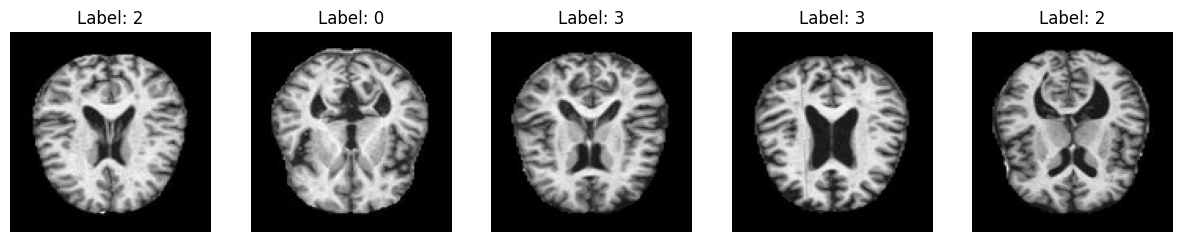

In [2]:
import matplotlib.pyplot as plt

# Display the first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(train_df['image'].iloc[i], cmap='gray')
    axes[i].set_title(f'Label: {train_df["label"].iloc[i]}')
    axes[i].axis('off')
plt.show()

In [3]:
# Check image shape
print("Image shape:", train_df['image'].iloc[0].shape)
print("Label distribution:", train_df['label'].value_counts())

Image shape: (128, 128)
Label distribution: label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Assuming images are grayscale, add channel dimension
images = np.array(train_df['image'].tolist())
images = images / 255.0  # Normalize to [0,1]
images = images[:, np.newaxis, :, :]  # Add channel dim: (N, 1, H, W)

# Convert labels to binary: 0 = healthy, else = Alzheimer's
labels = (train_df['label'] != 0).astype(int).values

# Split data
train_df_split, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df_split, val_df = train_test_split(train_df_split, test_size=0.2, random_state=42)

# Extract images and labels
X_train = np.array(train_df_split['image'].tolist())
y_train = (train_df_split['label'] != 0).astype(int).values
X_val = np.array(val_df['image'].tolist())
y_val = (val_df['label'] != 0).astype(int).values
X_test = np.array(test_df['image'].tolist())
y_test = (test_df['label'] != 0).astype(int).values

# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Add channel dim
X_train = X_train[:, np.newaxis, :, :]
X_val = X_val[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Assuming input size 128x128, adjust if different
        self.fc2 = nn.Linear(128, 2)  # Binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN()  # Reinitialize model for fresh training
model.to(device)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.cpu().numpy()), y=y_train.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {100*correct/total:.2f}%')

Epoch 1/20, Train Loss: 0.7260, Val Loss: 0.6932, Val Acc: 84.88%
Epoch 2/20, Train Loss: 0.6928, Val Loss: 0.6935, Val Acc: 84.88%
Epoch 3/20, Train Loss: 0.6928, Val Loss: 0.6937, Val Acc: 84.88%
Epoch 4/20, Train Loss: 0.6925, Val Loss: 0.6938, Val Acc: 84.88%
Epoch 5/20, Train Loss: 0.6923, Val Loss: 0.6942, Val Acc: 84.88%
Epoch 6/20, Train Loss: 0.6926, Val Loss: 0.6941, Val Acc: 84.88%
Epoch 7/20, Train Loss: 0.6927, Val Loss: 0.6940, Val Acc: 84.88%
Epoch 8/20, Train Loss: 0.6920, Val Loss: 0.6939, Val Acc: 84.88%
Epoch 9/20, Train Loss: 0.6926, Val Loss: 0.6941, Val Acc: 84.88%
Epoch 10/20, Train Loss: 0.6925, Val Loss: 0.6941, Val Acc: 84.88%
Epoch 11/20, Train Loss: 0.6924, Val Loss: 0.6941, Val Acc: 84.88%
Epoch 12/20, Train Loss: 0.6925, Val Loss: 0.6941, Val Acc: 84.88%
Epoch 13/20, Train Loss: 0.6925, Val Loss: 0.6942, Val Acc: 84.88%
Epoch 14/20, Train Loss: 0.6924, Val Loss: 0.6940, Val Acc: 84.88%
Epoch 15/20, Train Loss: 0.6923, Val Loss: 0.6945, Val Acc: 84.88%
Epoc

In [18]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['Healthy', 'Alzheimer\'s']))

              precision    recall  f1-score   support

     Healthy       0.73      0.92      0.81       136
 Alzheimer's       0.99      0.95      0.97       888

    accuracy                           0.94      1024
   macro avg       0.86      0.93      0.89      1024
weighted avg       0.95      0.94      0.95      1024



In [22]:
# Save updated predictions to CSV
import pandas as pd

df = pd.DataFrame({'ID': list(range(len(all_labels))), 'Name': ['Healthy' if l == 0 else 'Alzheimer' for l in all_labels], 'Actual': all_labels, 'Predicted': all_preds})
df.to_csv('predictions.csv', index=False)
print("Updated predictions.csv with new model")

Updated predictions.csv with new model


In [17]:
# Evaluate on test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
	for inputs, labels in test_loader:
		inputs, labels = inputs.to(device), labels.to(device)
		outputs = model(inputs)
		loss = criterion(outputs, labels)
		test_loss += loss.item()
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

acc = correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {acc*100:.2f}%")

Test Loss: 0.1938, Test Accuracy: 94.43%


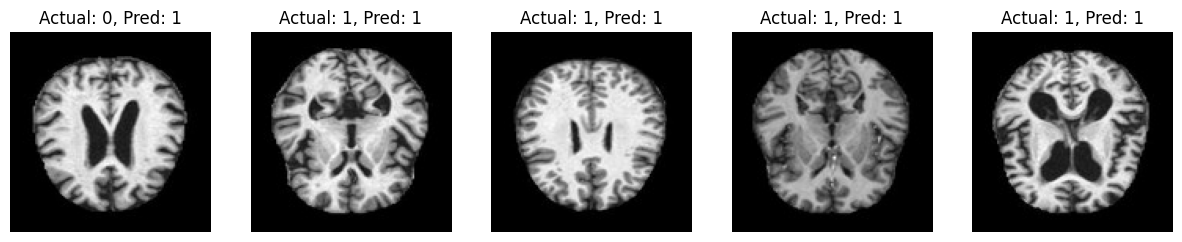

In [9]:
# Make predictions on test set samples
model.eval()
with torch.no_grad():
    # Get a batch from test_loader
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
    # Display some images with predictions
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(inputs[i].cpu().squeeze(), cmap='gray')
        axes[i].set_title(f'Actual: {labels[i].item()}, Pred: {predicted[i].item()}')
        axes[i].axis('off')
    plt.show()

In [19]:
# Update CSV with ID and Name
df = pd.read_csv('predictions.csv')
df['ID'] = range(len(df))
df['Name'] = ['Healthy' if a == 0 else 'Alzheimer' for a in df['Actual']]
df = df[['ID', 'Name', 'Actual', 'Predicted']]
df.to_csv('predictions.csv', index=False)
print("Updated predictions.csv with ID and Name")

Updated predictions.csv with ID and Name


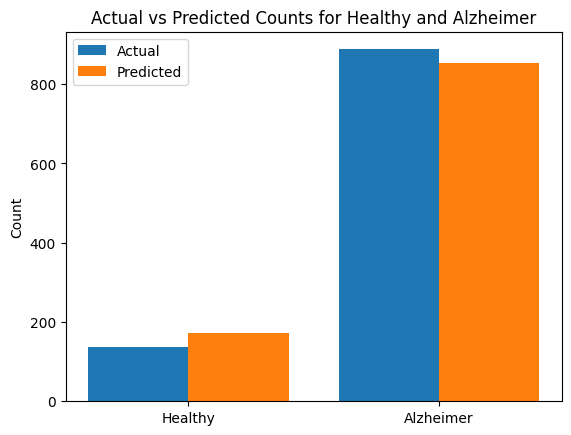

Actual counts: {0: 136, 1: 888}
Predicted counts: {0: 171, 1: 853}


In [23]:
# Plot graph of actual and predicted counts
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('predictions.csv')

actual_counts = df['Actual'].value_counts().sort_index()
pred_counts = df['Predicted'].value_counts().sort_index()

labels = ['Healthy', 'Alzheimer']
x = range(len(labels))

plt.bar(x, actual_counts, width=0.4, label='Actual', align='center')
plt.bar([i + 0.4 for i in x], pred_counts, width=0.4, label='Predicted', align='center')

plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Count')
plt.title('Actual vs Predicted Counts for Healthy and Alzheimer')
plt.legend()
plt.show()

print("Actual counts:", actual_counts.to_dict())
print("Predicted counts:", pred_counts.to_dict())

In [4]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Assuming input size 128x128, adjust if different
        self.fc2 = nn.Linear(128, 2)  # Binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNN()

True Label : Alzheimer
Prediction : Alzheimer
Confidence : 0.52
Result     : ✅ Correct
----------------------------------------


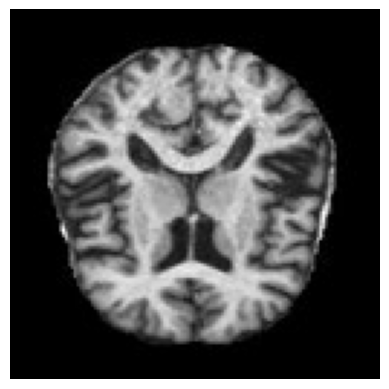

True Label : Healthy
Prediction : Alzheimer
Confidence : 0.52
Result     : ❌ Wrong
----------------------------------------


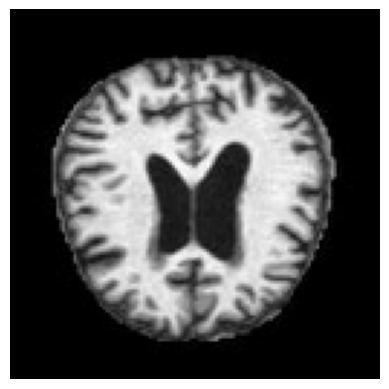

True Label : Alzheimer
Prediction : Alzheimer
Confidence : 0.52
Result     : ✅ Correct
----------------------------------------


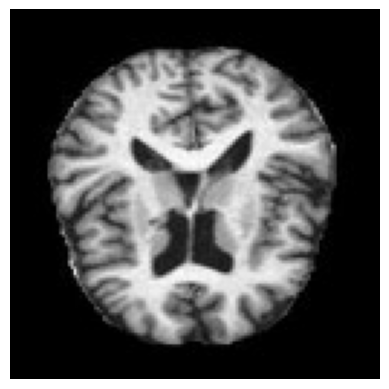

True Label : Alzheimer
Prediction : Alzheimer
Confidence : 0.52
Result     : ✅ Correct
----------------------------------------


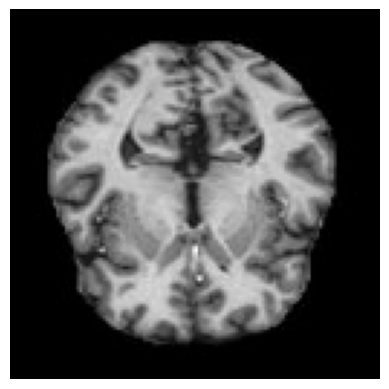

True Label : Alzheimer
Prediction : Alzheimer
Confidence : 0.52
Result     : ✅ Correct
----------------------------------------


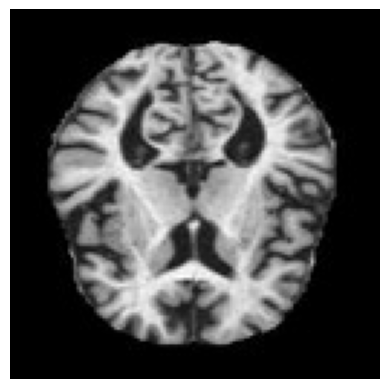

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

# Run multiple random tests
# Define model if not already defined (ensure previous cells defining CNN and training are run for a trained model)
if 'model' not in globals():
    model = CNN()  # Assuming CNN class is defined in previous cells
    model.to(device if 'device' in globals() else torch.device('cpu'))

model.eval()
with torch.no_grad():
    for _ in range(5):
        idx = random.randint(0, len(X_test) - 1)

        img = X_test[idx].unsqueeze(0).to(device)  # Add batch dim and move to device
        true_label = y_test[idx].item()

        # Model prediction
        outputs = model(img)
        probs = torch.softmax(outputs, dim=1)
        prob = probs[0][1].item()  # Probability for Alzheimer's (class 1)
        pred = int(prob > 0.5)

        # Display image
        plt.imshow(X_test[idx].cpu().squeeze(), cmap="gray")
        plt.axis("off")

        # Print results
        print(f"True Label : {'Alzheimer' if true_label else 'Healthy'}")
        print(f"Prediction : {'Alzheimer' if pred else 'Healthy'}")
        print(f"Confidence : {prob:.2f}")
        print("Result     :", "✅ Correct" if pred == true_label else "❌ Wrong")
        print("-" * 40)

        plt.show()